In [1]:
import numpy as np
from scipy.linalg import expm, logm
import openqcs as op
from openqcs.tools import color_matrix, get_su2_param, su2, diagonalize
from openqcs.iterativ import get_iterative_kraus_op
import time

## Example 2 site spin chain

In [2]:
X = np.matrix([[0,1],[1,0]])
Z = np.matrix([[1,0],[0,-1]])
Id = np.matrix(np.eye(2))
a = 0.5
b = 0.5
dt=0.01

def H_(a,b):
    return -a * np.kron(Z, Z) + b*(np.kron(X,Id) + np.kron(Id, X))

def T_(H, dt):
    if not isinstance(H, np.matrix):
        raise ValueError()
    return np.matrix(expm(-1j*H*dt))

H = H_(a,b)
T = T_(H, dt)


def iterative_evolution(T, sysbit=0):
    nbits = np.log2(T.shape[0])
    if nbits!=2:
        raise ValueError()
        
    
    valid = True
    n_t = 1
    n_kraus = 2**(nbits-1)
    
    data = []
    err = []
    neg_det = []
    
    rho_0 = np.matrix([[1,0],[0,0]], dtype=np.complex)
    rho_in = rho_0
    

    
    while valid:
        print("#", end="", flush=True)
        Ks = op.get_kraus_(T**n_t)
        rho_out = op.channel_(rho_0, Ks)
        
        
        p, S0, S1, msg = get_iterative_kraus_op(rho_in, rho_out, variant=0)
    
        p_prev = 0
        #if np.abs(p_prev - p) > 0.1:
        #    tmp = S1
        #    S1 = S0
        #    S0 = tmp
        #    p = 1-p
        
        #if np.isclose(np.linalg.det(S0),-1):
        #    p, S1, S0, msg = get_iterative_kraus_op(rho_in, rho_out, variant=1)
        #    neg_det.append(n_t*dt)
            
            
        #if np.isclose(np.linalg.det(S1),-1):
        #    p, S0, S1, msg = get_iterative_kraus_op(rho_in, rho_out, variant=1)
        #    neg_det.append(n_t*dt)
        valid = msg.ier
        
        if valid:
            p0 = get_su2_param(S0)
            p1 = get_su2_param(S1)
            
            data.append([p] + list(p0) + list(p1))
            err.append(msg.err)
            
            n_t += 1
            
        rho_in = rho_out
        
    print("\nvalid time steps: ", n_t-1)
    data = np.array(data)
    err = np.array(err)
    
    
    return data, err, n_t-1, neg_det
        
    
        
        
        
        
data, err, n_t, neg_det = iterative_evolution(T)
        
        
        
print(neg_det)


    


##########################################################################################################################################################################################################################################################################################
valid time steps:  281
[]


281
(281,)


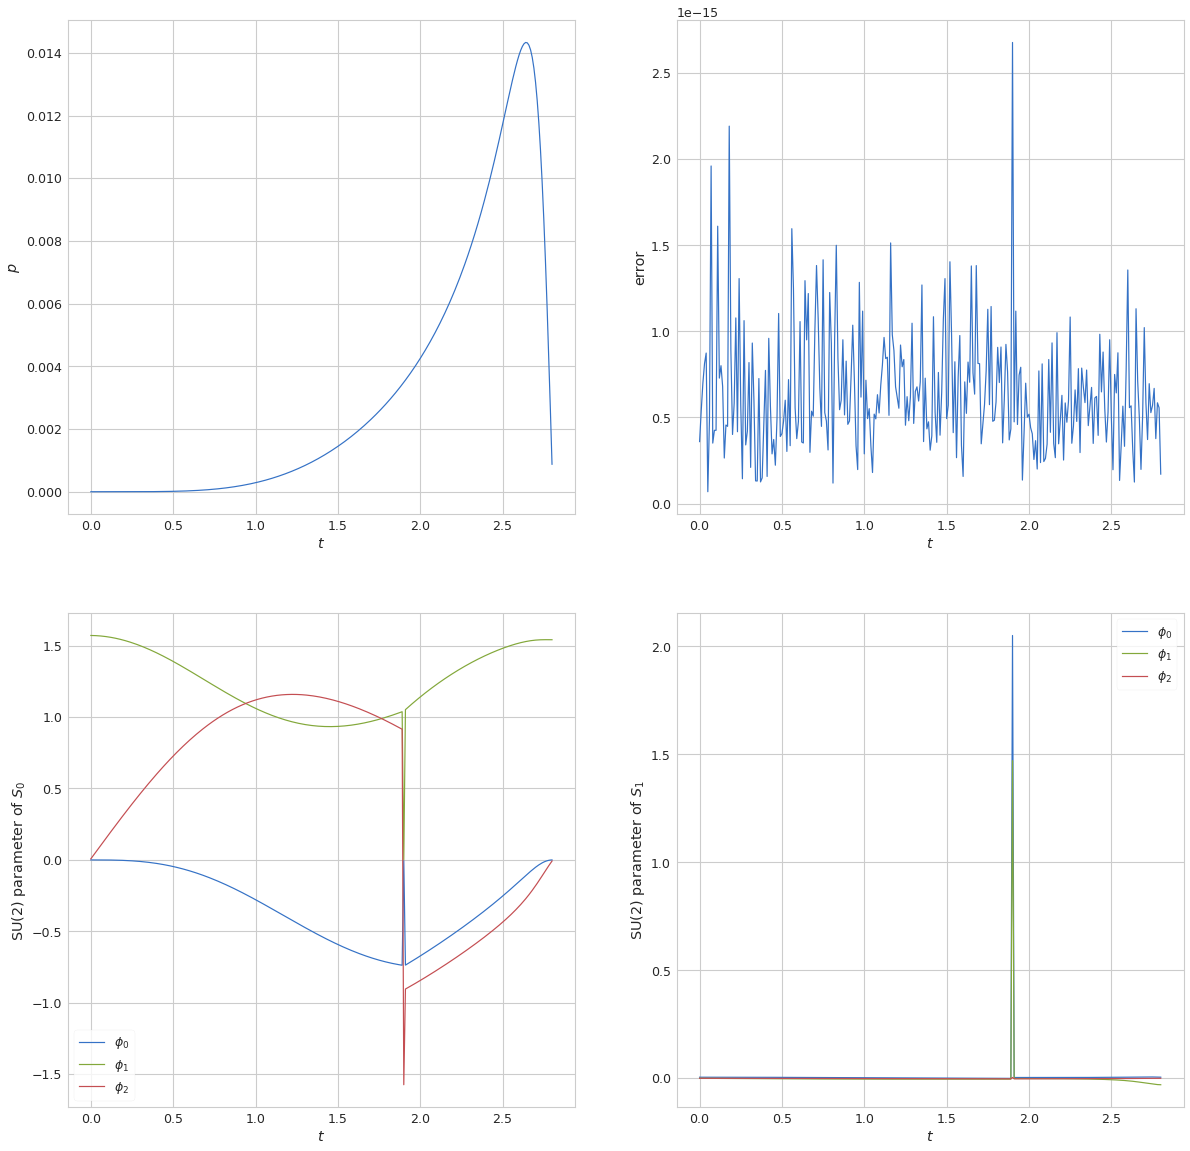

In [3]:
import matplotlib.pyplot as plt
print(n_t)
labeling=["$\phi_0$", "$\phi_1$", "$\phi_2$"]

time = np.arange(n_t)*dt
print(time.shape)
fig, axes = plt.subplots(2,2,figsize=(20,20))

axes[0,0].plot(time, data[:,0])
axes[0,0].set_ylabel("$p$")
axes[0,0].set_xlabel("$t$")

axes[0,1].plot(time, err)
axes[0,1].set_ylabel("error")
axes[0,1].set_xlabel("$t$")

for i in range(3):
    axes[1,0].plot(time, data[:,1+i], label=labeling[i])
    axes[1,1].plot(time, data[:,4+i], label=labeling[i])
    
axes[1,0].legend()
axes[1,0].set_ylabel("SU(2) parameter of $S_0$")
axes[1,0].set_xlabel("$t$")
axes[1,1].legend()
axes[1,1].set_ylabel("SU(2) parameter of $S_1$")
axes[1,1].set_xlabel("$t$")

#plt.savefig("plot_solution.png", format="png")

plt.show()



In [53]:
rho_0 = np.matrix([[1,0],[0,0]], dtype=np.complex)
values = []
rhos = []
times = []
n_t = 1
while n_t*dt < 2.5:
    Ks = op.get_kraus_(T**n_t)
    rho_out = op.channel_(rho_0, Ks)
    rhos.append(rho_out)
    v, w = np.linalg.eig(rho_out)
    
    if v[0] < v[1]:
        v, w = np.linalg.eig(X@rho_out@X)
    values.append(v)
    times.append(dt*n_t)
    n_t+=1

rhos = np.array(rhos)
values = np.array(values)
times = np.array(times)
    

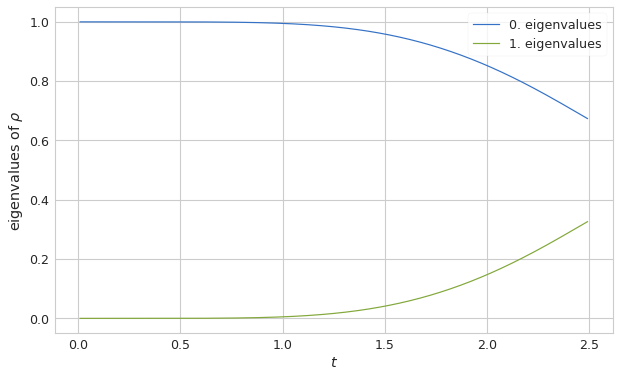

In [54]:
fig = plt.figure(figsize=(10,6))

for i in range(2):
    plt.plot(times, values[:,i].real, label="{}. eigenvalues".format(i))
    
plt.legend()
plt.xlabel("$t$")
plt.ylabel("eigenvalues of " + r"$\rho$")
plt.savefig("eigenvalues.png", format="png")
plt.show()

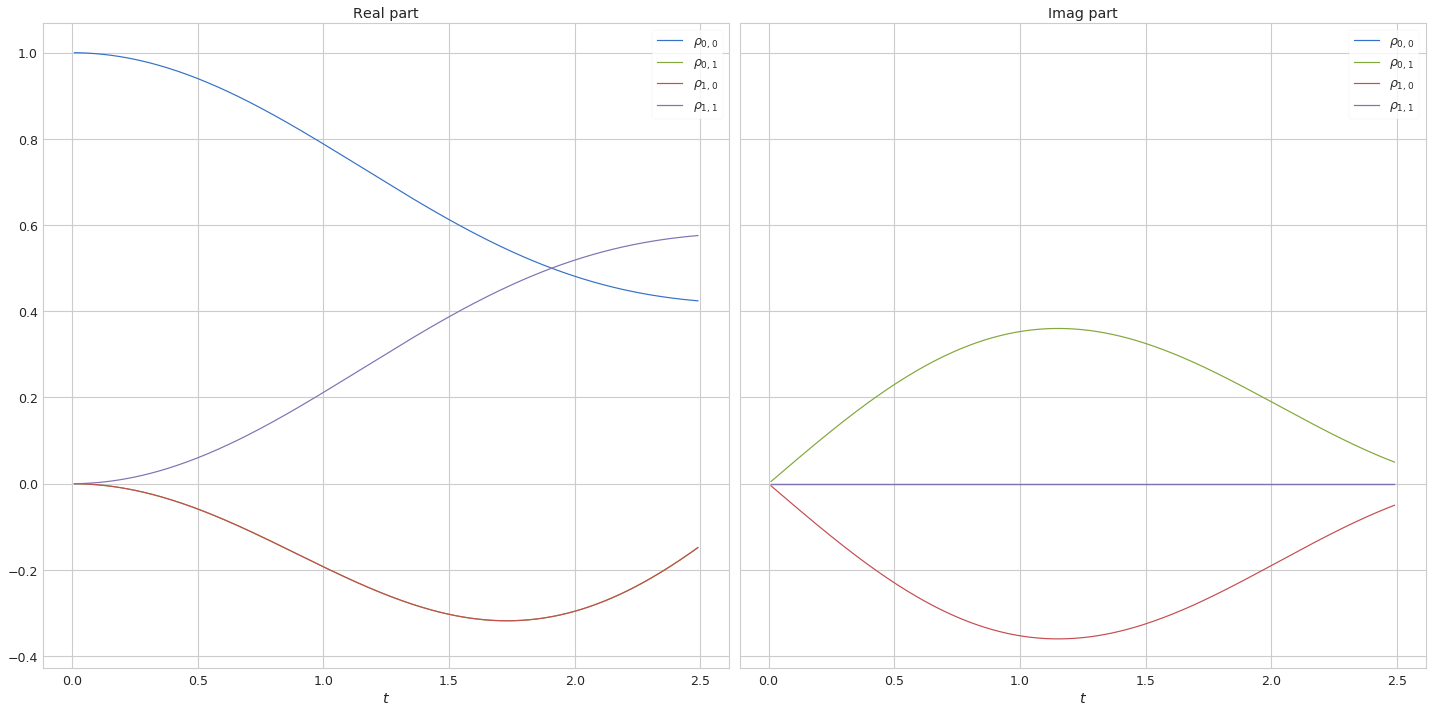

In [55]:
fig, axes = plt.subplots(1,2,figsize=(20,10), sharey=True)

for i in range(2):
    for j in range(2):
        axes[0].plot(times, rhos[:,i,j].real, label=r"$\rho_{%d,%d}$"%(i,j))
        axes[1].plot(times, rhos[:,i,j].imag, label=r"$\rho_{%d,%d}$"%(i,j))
axes[0].set_title("Real part")
axes[1].set_title("Imag part")
for i in range(2):
    axes[i].set_xlabel("$t$")
    axes[i].legend()
plt.tight_layout()
plt.savefig("density_matrix.png", format="png")
plt.show()

### Note:

The discontinuity comes from the fact, that at that point $\rho_{0,0}$ becomes smaller than $\rho_{1,1}$

In [56]:
idx = np.where(data[:,4]>0.1)[0][0]

#X = np.matrix([[0,1],[1,0]])
#Y = np.matrix([[0,-1j],[1j,0]])

Ks = op.get_kraus_(T**(idx))
rho_in = op.channel_(rho_0, Ks)

Ks = op.get_kraus_(T**(idx+1))
rho_out = op.channel_(rho_0, Ks)

p, S0, S1, msg = get_iterative_kraus_op(rho_in, rho_out, variant=0)


In [57]:
# projection from left
param = data[idx-1,:]
Diff = rho_out - (p * su2(param[1:4])@rho_in@su2(param[1:4]).H + (1-p)*su2(param[4:])@rho_in@su2(param[4:]).H)
print(np.linalg.norm(Diff))

0.008083309145687313


In [58]:
# projection from right
param = data[idx+1,:]
Diff = rho_out - (p * su2(param[1:4])@rho_in@su2(param[1:4]).H + (1-p)*su2(param[4:])@rho_in@su2(param[4:]).H)
print(np.linalg.norm(Diff))

0.0024282637972988935


In [59]:
Y = np.matrix([[0, -1j],[1j, 0]])
Id = np.matrix(np.eye(2),dtype=np.complex)


## Brute force minimization in 2nd region

In [83]:
from scipy.optimize import minimize

def loss(param, rho_in, rho_out):
    p = param[0]
    para0 = param[1:4]
    para1 = param[4:]
    
    S0 = su2(para0)
    S1 = su2(para1)
    
    return np.linalg.norm(rho_out - p*S0@rho_in@S0.H - (1-p)*S1@rho_in@S1.H)

def get_param(param0, rho_in, rho_out):
    
    sol = minimize(loss, param0, args=(rho_in, rho_out), tol=1e-10)
    
    return sol.x, sol.fun
    


def further_evolution(p_idx, T, dt, t_total):
    
    Param = []
    Err = []
    Time = []
    
    rho0 = np.matrix([[1,0],[0,0]], dtype=np.complex)
    
    i = p_idx-2
    
    Ks = op.get_kraus_(T**(i))
    rho_in = op.channel_(rho0, Ks)
    
    Ks = op.get_kraus_(T**(i+1))
    rho_out = op.channel_(rho0, Ks)
    
    
    p, S0, S1, msg = get_iterative_kraus_op(rho_in, rho_out, variant=0)
    
    param0 = [p] + list(get_su2_param(S0)) + list(get_su2_param(S1))
    param0 = np.array(param0)
    Param.append(param0)
    
    i += 1
    rho_in = rho_out
    
    while i*dt < t_total:
        print("#", end="", flush=True)
        Ks = op.get_kraus_(T**(i+1))
        Time.append(i*dt)
        rho_out = op.channel_(rho0, Ks)
        
        param0, err = get_param(param0, rho_in, rho_out)
        Err.append(err)
        Param.append(param0)
        rho_in = rho_out
        i+=1
        
    Param = np.array(Param)
    Err = np.array(Err)
    Time = np.array(Time)
    return Time, Param, Err

Time, Param, Err = further_evolution(idx, T, dt, 2.9)
        
        
        
print(dt) 
        

#####################################################################################################0.01


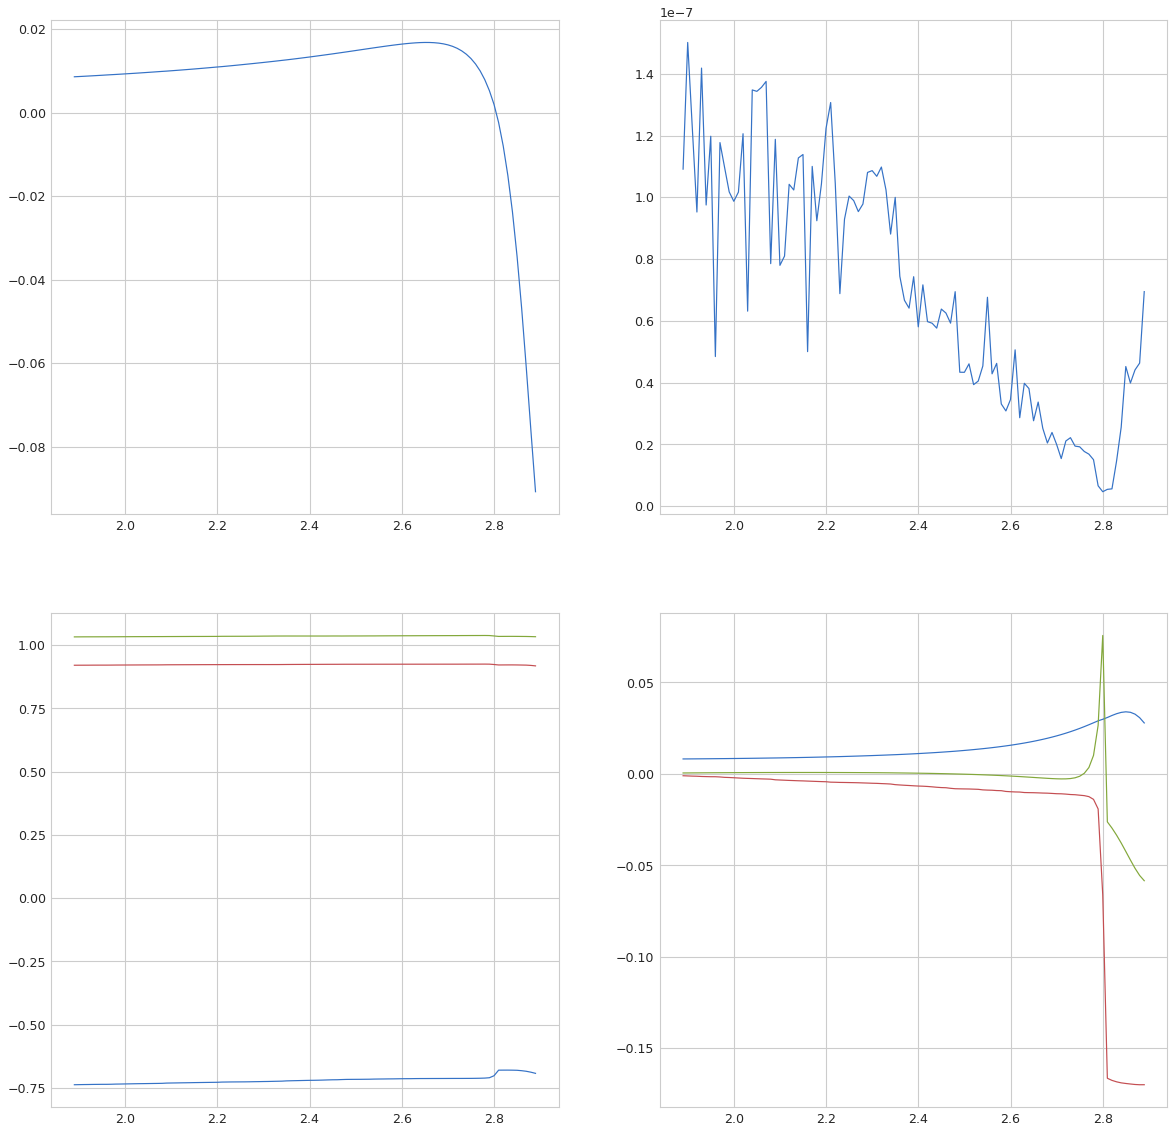

In [84]:
fig, axes = plt.subplots(2,2,figsize=(20,20))

axes[0,0].plot(Time, Param[1:,0])
axes[0,1].plot(Time, Err)
for i in range(3):
    axes[1,0].plot(Time, Param[1:,1+i])
    axes[1,1].plot(Time, Param[1:,4+i])
    
plt.show()



281
(281,)


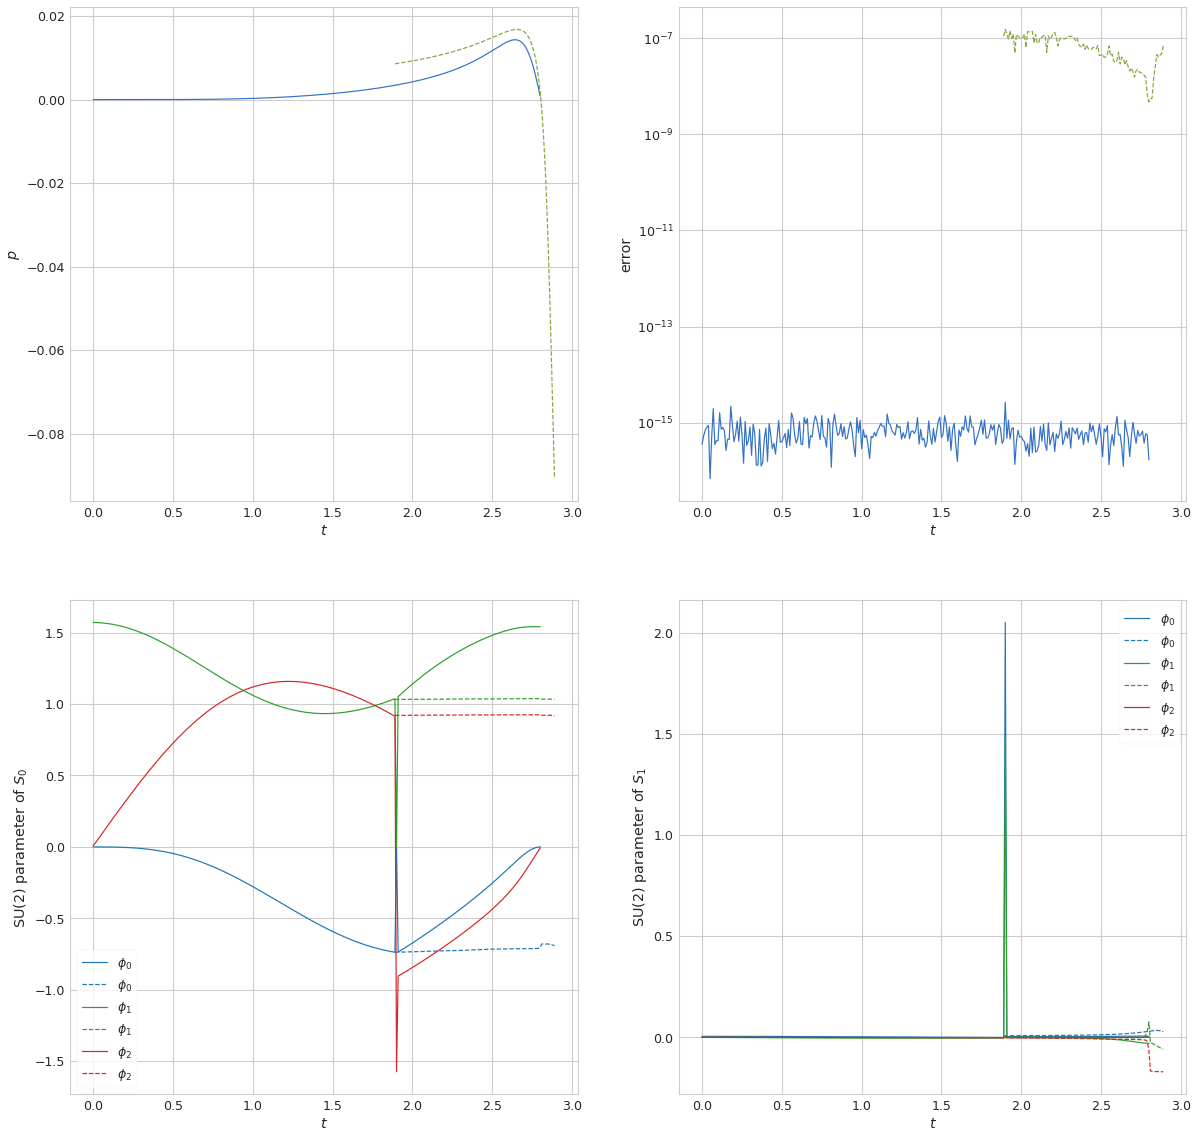

In [85]:
labeling=["$\phi_0$", "$\phi_1$", "$\phi_2$"]
color=["tab:blue", "tab:green", "tab:red"]
print(n_t)
time = np.arange(n_t)*dt
print(time.shape)
fig, axes = plt.subplots(2,2,figsize=(20,20))

axes[0,0].plot(time, data[:,0])
axes[0,0].plot(Time, Param[1:,0], linestyle="--")
axes[0,0].set_ylabel("$p$")
axes[0,0].set_xlabel("$t$")

axes[0,1].plot(time, err)
axes[0,1].plot(Time, Err, linestyle="--")
axes[0,1].set_ylabel("error")
axes[0,1].set_xlabel("$t$")
axes[0,1].set_yscale("log")

for i in range(3):
    axes[1,0].plot(time, data[:,1+i], label=labeling[i], color=color[i])
    axes[1,0].plot(Time, Param[1:,1+i], label=labeling[i], linestyle="--", color=color[i])
    axes[1,1].plot(time, data[:,4+i], label=labeling[i], color=color[i])
    axes[1,1].plot(Time, Param[1:,4+i], label=labeling[i], linestyle="--", color=color[i])
    
axes[1,0].legend()
axes[1,0].set_ylabel("SU(2) parameter of $S_0$")
axes[1,0].set_xlabel("$t$")
axes[1,1].legend()
axes[1,1].set_ylabel("SU(2) parameter of $S_1$")
axes[1,1].set_xlabel("$t$")

#plt.savefig("plot_solution.png", format="png")

plt.show()



## Time for "phase transition"

\begin{equation}
    \rho_{00}(t) = \frac{\gamma + \gamma \cos(\alpha t)\cos(\gamma t) + \alpha \sin(\alpha t) \sin(\gamma t)}{2 \gamma},
\end{equation}

with
\begin{align}
    \gamma = \sqrt{\alpha^2 + 4 \beta^2}
\end{align}

In [75]:
from numpy import sin, cos, sqrt
from scipy.optimize import fsolve

def gamma(a, b):
    return sqrt(a**2 + 4*b**2)

def eq(t, a, b):
    g = gamma(a,b)
    return ((g + g*cos(a*t)*cos(g*t) + a*sin(a*t)*sin(g*t))/(2*g) - 1/2)


t0 = 0.2


a = 0.5
b = 0.5

t = fsolve(eq, t0, args=(a,b))

print("t = ", t[0])


t =  1.9084215666865099


/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log10


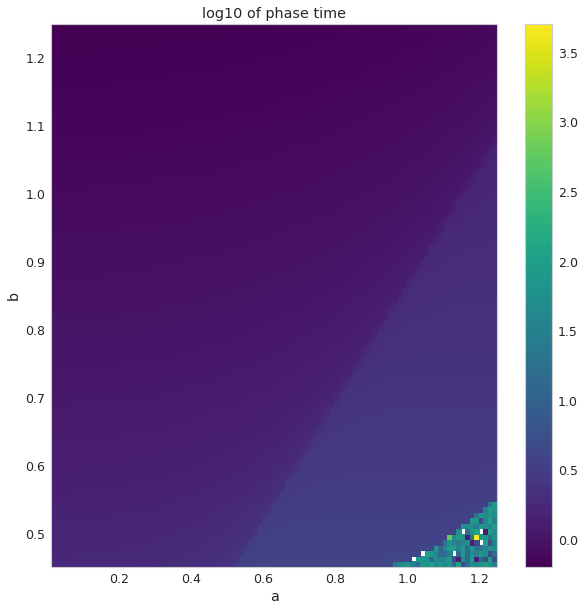

In [126]:
def ent_entropy(rho):
    return -np.trace(rho@logm(rho))

def get_crit_time(a, b, dt=0.05):
    H = H_(a,b)
    T = T_(H,dt)
    
    rho0 = np.matrix([[1,0],[0,0]], dtype=np.complex)
    
    ee = 0
    i = 0
    while True:
        Ks = op.get_kraus_(T**i)
        rho = op.channel_(rho0, Ks)
        
        ee_new = ent_entropy(rho)
        
        if ee_new < ee:
            return i*dt
        
        elif i*dt > 1000:
            return -1
        else:
            i += 1
            ee = ee_new

            
            
def phase_time(a,b):
    t0 = 1.0
    tp = fsolve(eq, t0, args=(a,b))
    i = 0
    while tp[0] < 0 or tp[0] > 4:
        t0 = np.random.rand()*100
        tp = fsolve(eq, t0, args=(a,b))
        i += 1
        if i == 1000:
            return tp[0]
    
    return tp[0]

N = 100
B = np.linspace(0.45, 1.25, N)
A = np.linspace(0.01, 1.25, N)


Val = np.zeros((N, N), dtype=float)
for i, b in enumerate(B):
    for j, a in enumerate(A):
        val = phase_time(a, b)

        Val[i,j]=np.log10(val)
    
cmap = plt.get_cmap('cool')
fig, ax = plt.subplots(figsize=(10,10))
img = ax.pcolormesh(A, B, Val)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_title("log10 of phase time")
fig.colorbar(img)
plt.show()
    